# Open Interest Data

In [11]:
import os
import sys

import dotenv
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [12]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from quantnote_query_api.query_api_client import QuantNoteQueryApi

## Create Query Api Client

In [13]:
dotenv.load_dotenv(".env")
AUTH_TOKEN = os.getenv("AUTH_TOKEN")
client = QuantNoteQueryApi(auth_token=AUTH_TOKEN, api_version="v1")
client

## Get Binance Pair

In [14]:
pair_symbol = 'BTCUSDT'
pair_query = """SELECT *
    FROM cex.binance.pairs
    WHERE symbol = '{symbol}';""".format(symbol=pair_symbol)

pair = client.get_data_response(pair_query)
pair

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,active,exchange,id,symbol
0,True,binance,1,BTCUSDT


## Get Open Interest

In [15]:
query = """SELECT date_trunc('hour', timestamp) as time,
       sum(cast(open_interest as double)) as open_interest,
       sum(cast(open_interest_value as double)) as open_interest_value
FROM cex.binance.open_interests
WHERE timestamp > timestamp '2023-03-30'
  and pair_id = {pair_id}
group by 1
order by 1;""".format(pair_id=pair['id'][0])

response = client.get_data_response(query)
response['time'] = pd.to_datetime(response['time'])
response['open_interest'] = pd.to_numeric(response['open_interest'])
response['open_interest_value'] = pd.to_numeric(response['open_interest_value'])
response

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,open_interest,open_interest_value,time
0,198651.062,5.616124e+09,2023-04-04 12:00:00+00:00
1,399220.675,1.127361e+10,2023-04-04 13:00:00+00:00
2,393406.589,1.107229e+10,2023-04-04 14:00:00+00:00
3,391854.770,1.099233e+10,2023-04-04 15:00:00+00:00
4,392273.013,1.099845e+10,2023-04-04 16:00:00+00:00
...,...,...,...
235,431109.337,1.331644e+10,2023-04-14 07:00:00+00:00
236,428156.007,1.315214e+10,2023-04-14 08:00:00+00:00
237,429496.931,1.319944e+10,2023-04-14 09:00:00+00:00
238,430294.460,1.324743e+10,2023-04-14 10:00:00+00:00


## Get TOHLCV

In [16]:
tohlcv_query = """SELECT time, p.symbol, open, high, low, close, volume, trades
FROM cex.binance.candles_hourly join cex.binance.pairs p on p.id = candles_hourly.pair_id
WHERE time > timestamp '2023-03-30'
  and pair_id = {token_id}
ORDER BY time;""".format(token_id=pair['id'][0])

tohlcv_resp = client.get_data_response(tohlcv_query)
tohlcv_resp['time'] = pd.to_datetime(tohlcv_resp['time'])
tohlcv_resp.set_index('time')
tohlcv_resp['open'] = pd.to_numeric(tohlcv_resp['open'])
tohlcv_resp['high'] = pd.to_numeric(tohlcv_resp['high'])
tohlcv_resp['low'] = pd.to_numeric(tohlcv_resp['low'])
tohlcv_resp['close'] = pd.to_numeric(tohlcv_resp['close'])
tohlcv_resp['volume'] = pd.to_numeric(tohlcv_resp['volume'])
tohlcv_resp

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,close,high,low,open,symbol,time,trades,volume
0,28350.00,28382.00,28245.06,28328.48,BTCUSDT,2023-03-30 01:00:00+00:00,51934.000000000000000000,1543.34488
1,28964.76,29184.68,28343.39,28350.00,BTCUSDT,2023-03-30 02:00:00+00:00,224546.000000000000000000,12850.87620
2,28489.18,29002.67,28090.06,28964.76,BTCUSDT,2023-03-30 03:00:00+00:00,192757.000000000000000000,12075.03577
3,28587.64,28701.96,28442.79,28489.19,BTCUSDT,2023-03-30 04:00:00+00:00,64768.000000000000000000,3571.44760
4,28613.98,28633.70,28491.39,28587.63,BTCUSDT,2023-03-30 05:00:00+00:00,51314.000000000000000000,2288.37147
...,...,...,...,...,...,...,...,...
367,30730.22,30788.47,30657.14,30733.73,BTCUSDT,2023-04-14 08:00:00+00:00,46257.000000000000000000,2525.37705
368,30794.16,30798.29,30700.00,30730.22,BTCUSDT,2023-04-14 09:00:00+00:00,37095.000000000000000000,1798.17559
369,30766.01,30827.27,30758.89,30794.16,BTCUSDT,2023-04-14 10:00:00+00:00,37375.000000000000000000,1912.71920
370,30801.89,30806.70,30727.63,30766.01,BTCUSDT,2023-04-14 11:00:00+00:00,30814.000000000000000000,1391.49261


## Plot Open Interest vs Price

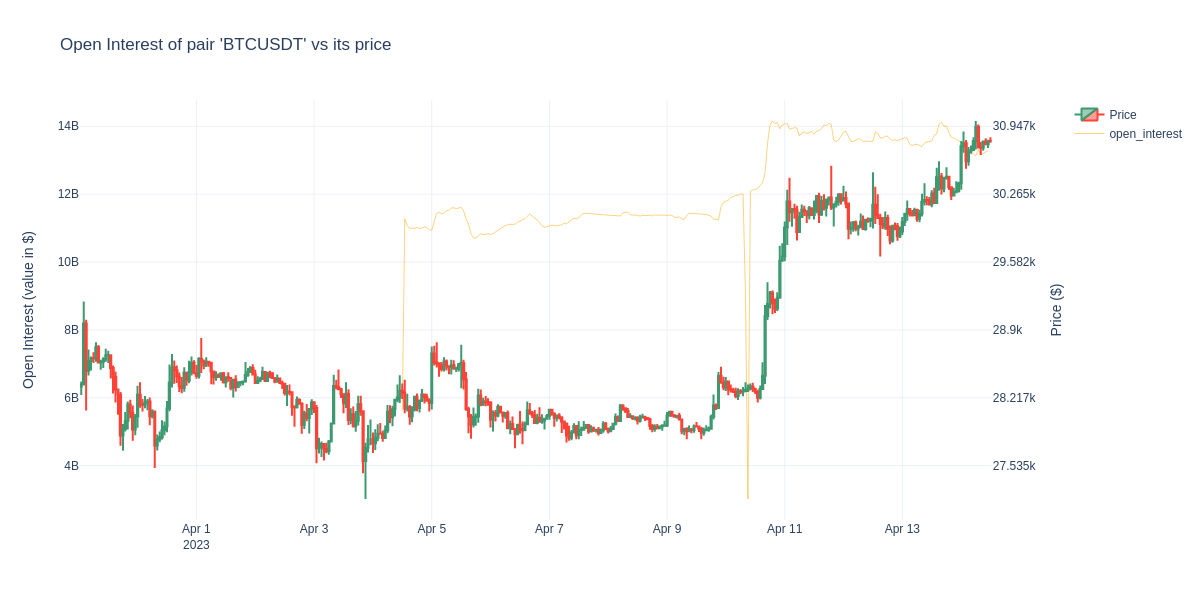

In [17]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

candlestick = go.Candlestick(
    x=tohlcv_resp['time'],
    open=tohlcv_resp['open'],
    high=tohlcv_resp['high'],
    low=tohlcv_resp['low'],
    close=tohlcv_resp['close'],
    name="Price"
)

open_interest = go.Scatter(x=response['time'],
                           y=response['open_interest_value'],
                           name="open_interest",
                           mode='lines',
                           line=dict(width=0.5, color='orange'),
                           )

fig.add_trace(candlestick, secondary_y=True)
fig.add_trace(open_interest, secondary_y=False)

fig.update_layout(
    width=1200, height=600,
    title="Open Interest of pair '{pair}' vs its price".format(pair=pair["symbol"][0]),
    xaxis_rangeslider_visible=False,
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(
        title="Open Interest (value in $)",
        tickmode="sync",
    ),
    yaxis2=dict(
        title="Price ($)",
        anchor="x",
        overlaying="y",
        side="right",
        tickmode="sync",
    ),
    template = "plotly_white"
)

# Set y-axes titles
fig.update_yaxes(title_text="Open Interest (value in $)", secondary_y=False)
fig.update_yaxes(title_text="Price ($)", secondary_y=True)

fig.show("png")